In [186]:
%pylab inline

import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.utils import np_utils
from keras.layers.core import Dense, Activation, Dropout

from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, roc_auc_score

import datetime, time

Populating the interactive namespace from numpy and matplotlib


In [187]:
# Read data
wnv_train = pd.read_csv('../working/train_f.csv')
wnv_test = pd.read_csv('../working/test_f.csv')

In [188]:
# convert list of labels to binary class matrix
labels = wnv_train.ix[:,1].values.astype('int')
yr_train = np_utils.to_categorical(labels)

In [189]:
# raw data
#yr_train = wnv_train[:,1].astype(int)
Xr_train =(wnv_train.ix[:,2:].values).astype('float64')
Xr_test = (wnv_test.ix[:,1:].values).astype('float64')

# normalize data
scaler = StandardScaler()
scaler.fit(Xr_train)
Xn_train = scaler.transform(Xr_train)
Xn_test = scaler.transform(Xr_test)

X_train, X_test, y_train, y_test = train_test_split(Xn_train, yr_train)

In [310]:
input_dim = Xn_train.shape[1]
nb_classes = y_train.shape[1]
hidden_dim = 256

hidden_layers = 5
dropout = 0.5

In [311]:
model = None

# create model
model = Sequential()
model.add(Dense(input_dim, hidden_dim, init='lecun_uniform'))
model.add(Activation('relu'))
model.add(Dropout(dropout))
for i in range(hidden_layers - 1):
    model.add(Dense(hidden_dim, hidden_dim, init='lecun_uniform'))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
model.add(Dense(hidden_dim, nb_classes, init='lecun_uniform'))
model.add(Activation('softplus'))

In [312]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer='Adam')

In [313]:
print("Training...")
model.fit(X_train, y_train, nb_epoch=10, batch_size=16, validation_split=0.0, show_accuracy=True, verbose=1)

Training...
Epoch 0
7879/7879 [==============================] - 8s - loss: 0.2095 - acc.: 0.9491     
Epoch 1
7879/7879 [==============================] - 8s - loss: 0.1729 - acc.: 0.9490     
Epoch 2
7879/7879 [==============================] - 8s - loss: 0.1703 - acc.: 0.9491     
Epoch 3
7879/7879 [==============================] - 8s - loss: 0.1704 - acc.: 0.9491     
Epoch 4
7879/7879 [==============================] - 8s - loss: 0.1699 - acc.: 0.9492     
Epoch 5
7879/7879 [==============================] - 8s - loss: 0.1661 - acc.: 0.9492     
Epoch 6
7879/7879 [==============================] - 8s - loss: 0.1682 - acc.: 0.9490     
Epoch 7
7879/7879 [==============================] - 9s - loss: 0.1700 - acc.: 0.9491     
Epoch 8
7879/7879 [==============================] - 9s - loss: 0.1664 - acc.: 0.9490     
Epoch 9
7879/7879 [==============================] - 8s - loss: 0.1637 - acc.: 0.9490     


In [314]:
preds = model.predict_classes(X_test, verbose=0)
proba = model.predict_proba(X_test, verbose=0)

In [315]:
# accuracy
matches = (preds == y_test[:,1])
print matches.sum() / float(len(matches))

# f1 score
print classification_report( y_test[:,1], preds)

# confusion matrix
print confusion_matrix( y_test[:,1], preds)

# auc
print roc_auc_score(y_test[:,1], proba[:,1])

0.942900647126
             precision    recall  f1-score   support

        0.0       0.94      1.00      0.97      2477
        1.0       0.00      0.00      0.00       150

avg / total       0.89      0.94      0.92      2627

[[2477    0]
 [ 150    0]]
0.843727627506


Area under the ROC curve : 0.843728


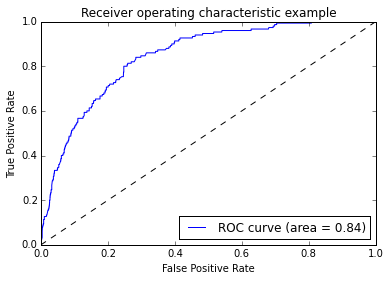

In [316]:
#np.max(proba[:,1])
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(y_test[:,1], proba[:,1])
roc_auc = auc(fpr, tpr)
print "Area under the ROC curve : %f" % roc_auc

# Plot ROC curve
plt.clf()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [294]:
proba = model.predict_proba(Xn_test)

116293/116293 [==============================] - 3s     


In [295]:
st = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S')

def write_preds(proba, fname):
    pd.DataFrame({"Id": list(range(1,len(proba)+1)), "WnvPresent": proba}).to_csv(fname, index=False, header=True)

#write_preds(preds[range(28000)], "keras-mlp_" + st + ".csv")
write_preds(proba[:,1], "../working/keras_test_" + st + ".csv")